In [1]:
import warnings
import datetime
import itertools
import numpy as np
import scipy as sp
import cvxpy as cp
import pandas as pd
import yfinance as yf
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
from functools import reduce
from kit import get_yf_ts, get_mcap, d1, d2, call

warnings.filterwarnings('ignore')

<b>Volatility $\sigma$</b> is a measure of variation of asset returns over time. It is defined as the standard deviation of a sequence of random variables, each of which is the log return of the asset over the defined time period
$$ \sigma_T = \sigma \sqrt{T},$$ for $\sigma_T$ being the annualized volatility.

This measure of riskiness is typically assessed on annual basis, hence the scaling factor of $\sqrt{T}$. In this context $T$ refers not to the period of measurement, rather the frequenecy of the measures. If the frequency of the measurements (data) is lower, the returns will move more, since the price has more time to move more between samples, resulting in higher standard deviation.

Regardless of the frequency, the final return in the period is the sum of the intermediate changes (product of returns). The sum of an i.i.d. $X$ is a random variable $Y$ which variance is $T\text{Var}(X)$ for $T$ steps sum, thus the volatility being $\sqrt{T\text{Var}(X)}$.

One can think of this as a normalization factor, where lower frequency data has a larger multiplier and vice-versa, to bring the riskiness (volatility) measure comparible at an annual level.

In [2]:
aapl_d, aapl_m = get_yf_ts('AAPL', '1y', '1d'), get_yf_ts('AAPL', '1y', '1mo')
aapl_returns_d, aapl_returns_m = (1 + np.log(aapl_d['AAPL'] / aapl_d['AAPL'].shift(1))), (1 + np.log(aapl_m['AAPL'] / aapl_m['AAPL'].shift(1)))

In [3]:
aapl_d_vol, aapl_m_vol = np.round(aapl_returns_d.std() * np.sqrt(252), 3), np.round(aapl_returns_m.std() * np.sqrt(12), 3)

In [4]:
print("AAPL annualized volatility from daily returns {} and from monthly returns {}".format(aapl_d_vol, aapl_m_vol))

AAPL annualized volatility from daily returns 0.227 and from monthly returns 0.238


Below we observe the annualized 21 trading day historical volatility of AAPL, 2005 onwards:

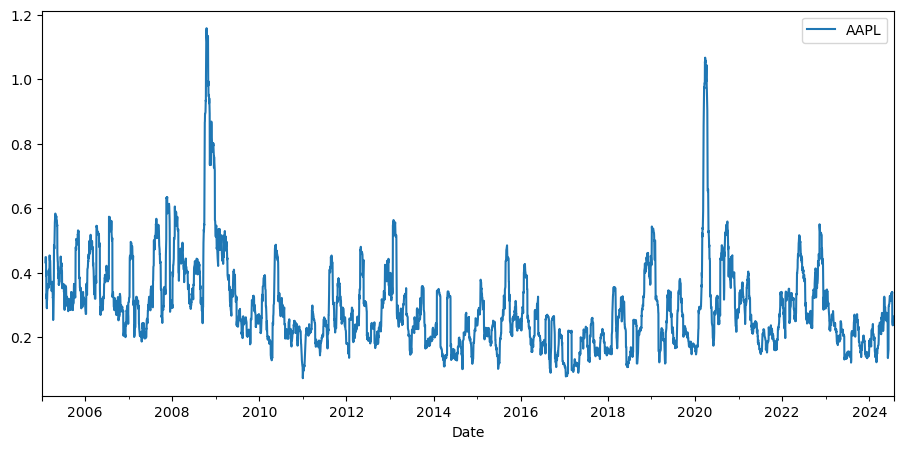

In [5]:
((1 + get_yf_ts('AAPL', 'max', '1d')['2005':].pct_change()).rolling(21).std() * np.sqrt(252)).plot(figsize=(11,5))
plt.show()

Volatility can also be marked via option contracts; <b>Implied volatility</b> of an option contract is the volatility of the underlying asset, which when factored in the option pricing model, will return a value equal to the market observable price of an option.

Below we build an implied volatility function using brute force. Knowing the call option price, the strike, spot, expiry and risk-free rate we can imply what the volatility of the asset should be to match the call option price.

In [142]:
def iv2(C, S, K, r, dt):
    for sigma in np.linspace(0.01, 3, 500):
        if (C - call(S, K, r, dt, sigma)) < 1e-4:
            return sigma

In [7]:
oc = yf.Ticker('AAPL').option_chain()[0] # The Yahoo Finance API gives 2 results, call options at [0] and put options [1]

In [8]:
oc_expiry = datetime.date(2024, 8, 2)
dt = (np.busday_count(datetime.date.today(), oc_expiry) + 1) / 251

In [9]:
oc[['contractSymbol', 'strike', 'lastPrice']].head() # Note the expiry date from the contract symbol

,contractSymbol,strike,lastPrice
0,AAPL240802C00100000,100.0,119.08
1,AAPL240802C00115000,115.0,100.06
2,AAPL240802C00125000,125.0,94.60
3,AAPL240802C00135000,135.0,84.23
4,AAPL240802C00140000,140.0,78.20


Using the AAPL call option prices from YF, and their strikes, we calculate the implied volatility and plot it against the strike. We observe the standard volatility smile curve, with an amount of skew showing that downside strikes have greater implied volatility that upside strikes. We assume a fixed price at $217 and risk free interest at 5%.

Both our calculated implied volatility and the one from Yahoo Finance overlap, the differences mainly arising from our assumptions of fixed price and risk-free rate.

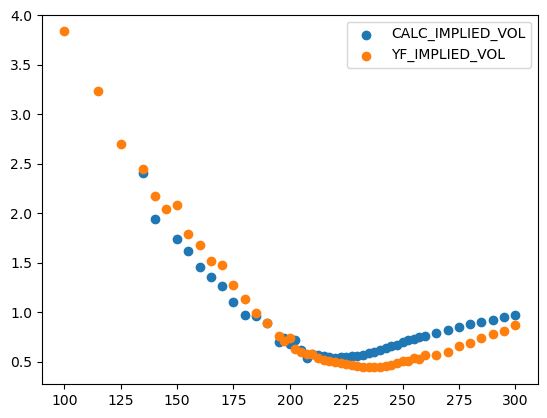

In [27]:
ro = pd.DataFrame()
for x in oc.loc[oc['strike']>125][['strike', 'lastPrice']].values:
    K, C = x
    sigma = iv2(C, 217, K, 0.05, dt)
    ro = ro.append(pd.DataFrame({'strike' : [K], 'C' : [C], 'implied_vol' : [sigma], 'S' : [217]}))
plt.scatter(ro['strike'], ro['implied_vol'], label='CALC_IMPLIED_VOL')
plt.scatter(oc['strike'], oc['impliedVolatility'], label='YF_IMPLIED_VOL')
plt.legend()
plt.show()

The <b>CBOE Volatility Index (VIX)</b>, represents the market's expectations of near-term volatility as conveyed by S&P 500 stock index option prices. It is a 30-day forward-looking volatility. It is not a direct measure of volatility but an implied one derived from option prices. The VIX is calculated using a wide range of S&P 500 index options, both calls and puts. The formula incorporates the prices of these options to produce an estimate of expected volatility. This involves a weighted average of the implied volatilities across different strike prices. Like all indices, the VIX cannot be bought directly, but there are numerous financial instruments based on it, such as VIX futures, options, and exchange-traded products (ETPs), allowing investors to speculate on or hedge against changes in market volatility.

Investors use the VIX to hedge against market risk. For instance, a rising VIX may prompt investors to take protective measures against potential declines in their portfolios. Some research suggests that the VIX can be a leading indicator of market movements. Rapid increases in the VIX often precede sharp declines in the stock market.

Below we observe the actual 30 trading day historical volatility of the S&P 500 and the implied volatility via the VIX index:

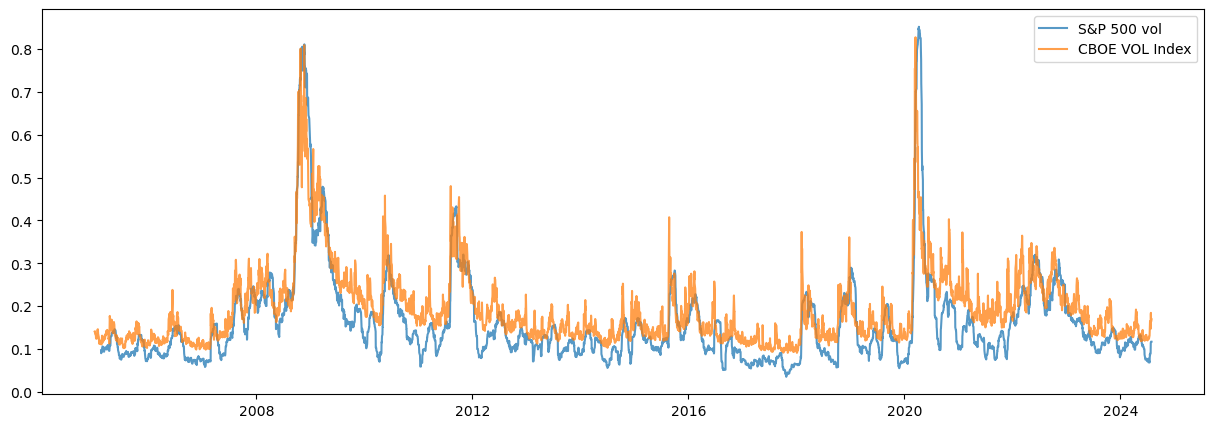

In [11]:
sp500_30dvol = (1 + get_yf_ts('^GSPC', 'max', '1d')['2005':].pct_change()).rolling(30).std() * np.sqrt(251)
cboe = (get_yf_ts('^VIX', 'max', '1d')/100)['2005':]

plt.figure(figsize=(15,5))
plt.plot(sp500_30dvol.index.to_timestamp(), sp500_30dvol['^GSPC'], label='S&P 500 vol', alpha=0.75)
plt.plot(cboe.index.to_timestamp(), cboe['^VIX'], label='CBOE VOL Index', alpha=0.75)
plt.legend()
plt.show()

Given a spot and a strike price for an asset, to price an option contract (either a call or a put) the only parameter not known is the volatility. The option price mainly changes depending what the strike is and the option expiry date, to understand better the volatility of the underlying, for a fixed spot and option price we plot the <b> volatility surface </b> showing the relationship between the volatility and the strike and expiration. Say C = $5.

In [125]:
vs = []
for dt in np.linspace(2/251, 3/4, 51):
    for strike in np.linspace(150, 250, 51):
        vs.append(pd.DataFrame({'dt' : [dt], 'K' : [strike], 'iv' : [iv2(5, 217, K, 0.05, dt)]}))

In [140]:
l = pd.concat(vs)